## EDA Analysis of Aerial Scene

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
dataset_dir = "/kaggle/input/aid-scene-classification-datasets/AID"  # Adjust if different

In [ ]:
image_paths = []
labels = []

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(".jpg"):
            image_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

data_df = pd.DataFrame({'image_path': image_paths, 'label': labels})
data_df.head()

,image_path,label
0,/kaggle/input/aid-scene-classification-dataset...,Mountain
1,/kaggle/input/aid-scene-classification-dataset...,Mountain
2,/kaggle/input/aid-scene-classification-dataset...,Mountain
3,/kaggle/input/aid-scene-classification-dataset...,Mountain
4,/kaggle/input/aid-scene-classification-dataset...,Mountain


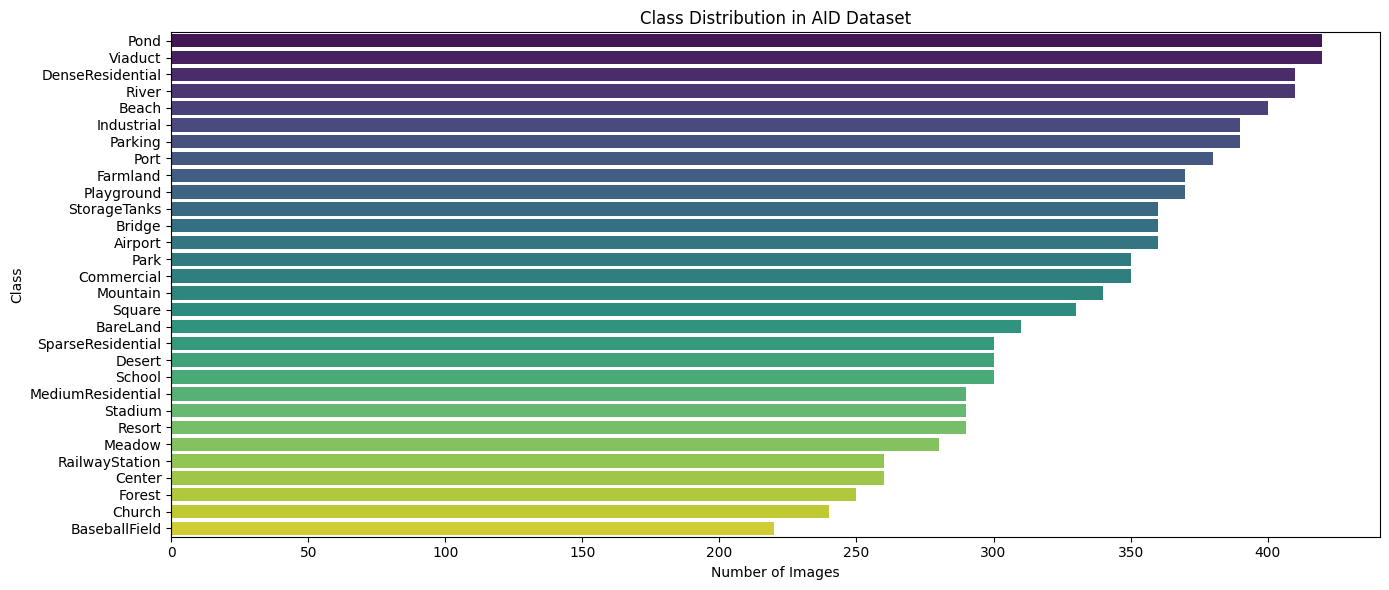

In [ ]:
plt.figure(figsize=(14, 6))
sns.countplot(y=data_df['label'], order=data_df['label'].value_counts().index, palette='viridis')
plt.title("Class Distribution in AID Dataset")
plt.xlabel("Number of Images")
plt.ylabel("Class")
plt.tight_layout()
plt.show()

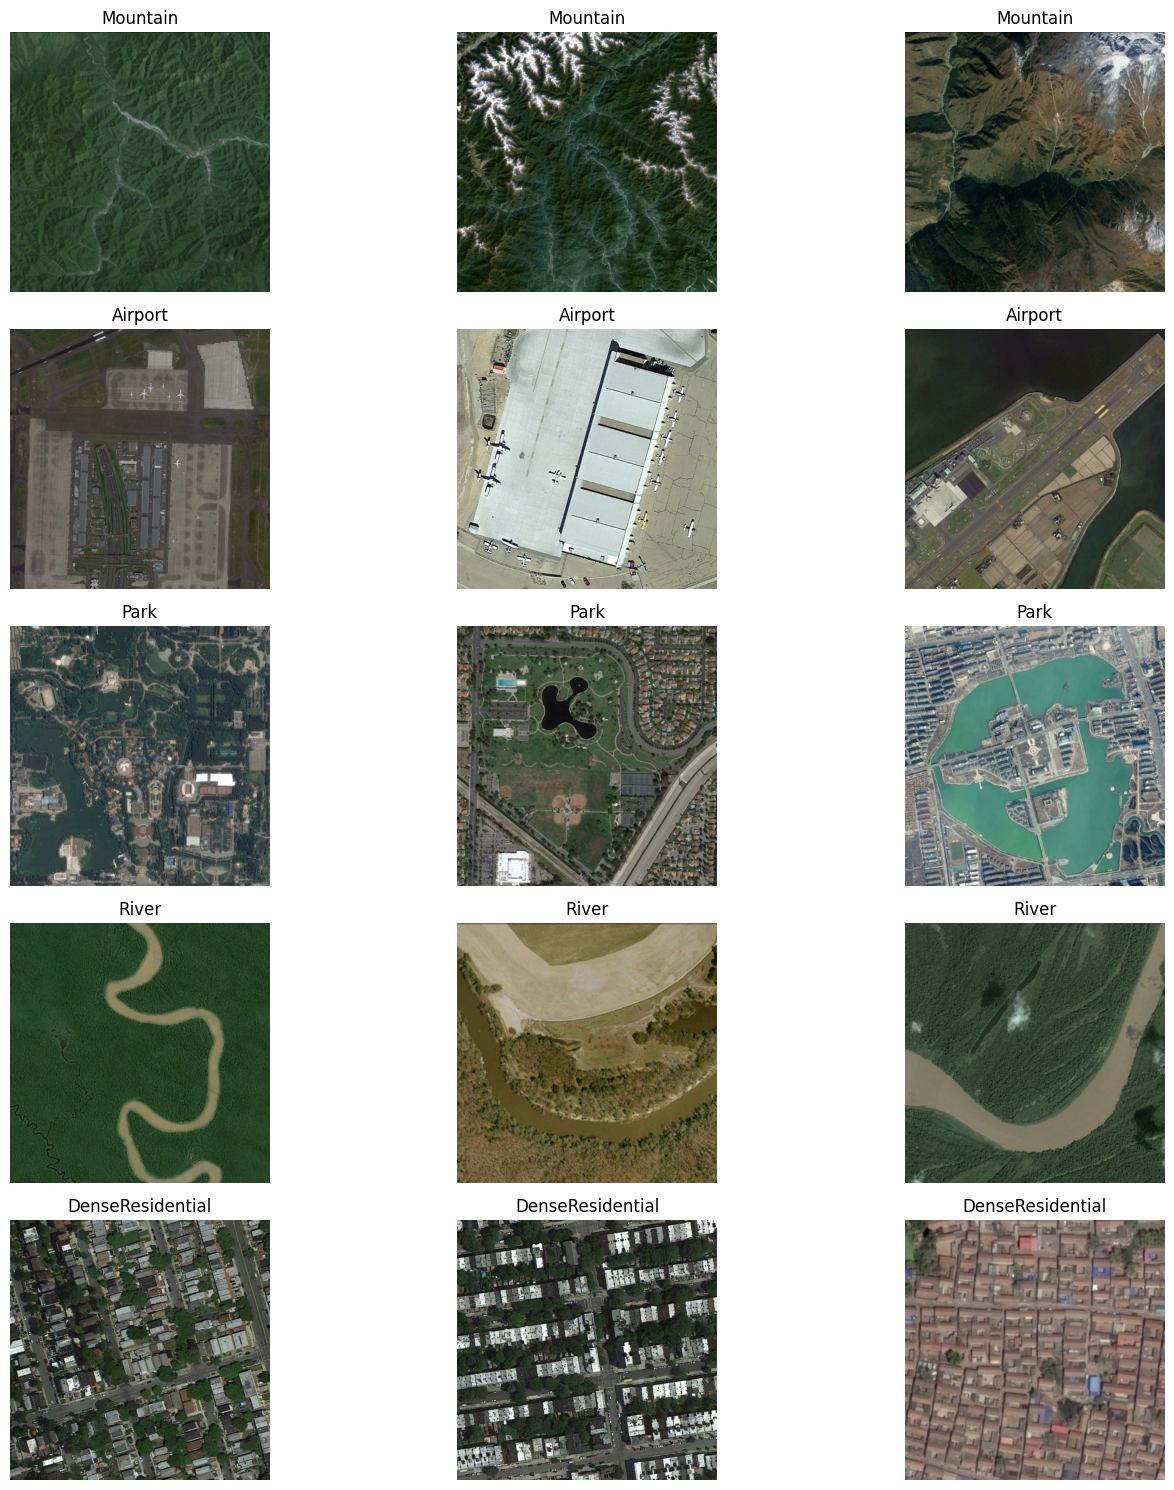

In [ ]:
def show_sample_images(df, classes, samples_per_class=3):
    plt.figure(figsize=(15, len(classes) * 3))
    for idx, cls in enumerate(classes):
        images = df[df['label'] == cls].sample(samples_per_class, random_state=42)
        for i, (path, label) in enumerate(zip(images['image_path'], images['label'])):
            plt_idx = idx * samples_per_class + i + 1
            plt.subplot(len(classes), samples_per_class, plt_idx)
            img = Image.open(path)
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

unique_classes = data_df['label'].unique()
show_sample_images(data_df, unique_classes[:5])  # show first 5 classes

# Splitting

In [36]:
import os
import pandas as pd
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image

In [37]:
# Define input dataset directory and output directory
dataset_dir = "/kaggle/input/aid-scene-classification-datasets/AID"  # Adjust if needed
output_base = "/kaggle/working/"

# Load image paths and labels
image_paths = []
labels = []

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(".jpg"):
            image_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

# Create DataFrame
data_df = pd.DataFrame({'image_path': image_paths, 'label': labels})
data_df.head()

,image_path,label
0,/kaggle/input/aid-scene-classification-dataset...,Mountain
1,/kaggle/input/aid-scene-classification-dataset...,Mountain
2,/kaggle/input/aid-scene-classification-dataset...,Mountain
3,/kaggle/input/aid-scene-classification-dataset...,Mountain
4,/kaggle/input/aid-scene-classification-dataset...,Mountain


In [38]:
# Encode labels for stratification
le = LabelEncoder()
data_df['label_encoded'] = le.fit_transform(data_df['label'])

In [50]:
# First split: Train and Temp (val + test)
train_df, temp_df = train_test_split(
    data_df,
    test_size=0.30,  # 30% for val + test
    stratify=data_df['label_encoded'],
    random_state=42
)

# Second split: Validation and Test (15% each)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,  # Split 30% into 15% val, 15% test
    stratify=temp_df['label_encoded'],
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 7000
Validation samples: 1500
Test samples: 1500


In [40]:
def save_split(split_name, split_df):
    split_path = os.path.join(output_base, split_name)
    os.makedirs(split_path, exist_ok=True)
    
    for label in split_df['label'].unique():
        label_dir = os.path.join(split_path, label)
        os.makedirs(label_dir, exist_ok=True)

    for _, row in split_df.iterrows():
        src = row['image_path']
        dst = os.path.join(split_path, row['label'], os.path.basename(src))
        shutil.copy2(src, dst)

In [41]:
save_split('train', train_df)
save_split('val', val_df)
save_split('test', test_df)

In [42]:
for split in ['train', 'val', 'test']:
    base = os.path.join(output_base, split)
    print(f"\n{split.upper()} split:")
    for class_name in sorted(os.listdir(base)):
        class_path = os.path.join(base, class_name)
        count = len(os.listdir(class_path))
        print(f"  {class_name}: {count} images")


TRAIN split:
  Airport: 252 images
  BareLand: 217 images
  BaseballField: 154 images
  Beach: 280 images
  Bridge: 252 images
  Center: 182 images
  Church: 168 images
  Commercial: 245 images
  DenseResidential: 287 images
  Desert: 210 images
  Farmland: 259 images
  Forest: 175 images
  Industrial: 273 images
  Meadow: 196 images
  MediumResidential: 203 images
  Mountain: 238 images
  Park: 245 images
  Parking: 273 images
  Playground: 259 images
  Pond: 294 images
  Port: 266 images
  RailwayStation: 182 images
  Resort: 203 images
  River: 287 images
  School: 210 images
  SparseResidential: 210 images
  Square: 231 images
  Stadium: 203 images
  StorageTanks: 252 images
  Viaduct: 294 images

VAL split:
  Airport: 54 images
  BareLand: 47 images
  BaseballField: 33 images
  Beach: 60 images
  Bridge: 54 images
  Center: 39 images
  Church: 36 images
  Commercial: 53 images
  DenseResidential: 61 images
  Desert: 45 images
  Farmland: 55 images
  Forest: 38 images
  Industrial

# Training

## Imports & Device

In [43]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


## Data Transforms & Dataloaders

In [44]:
data_dir = "/kaggle/working/"
batch_size = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.2,0.2,0.2,0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train','val','test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=batch_size,
                                              shuffle=(x=='train'),
                                              num_workers=4)
               for x in ['train','val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val','test']}
class_names   = image_datasets['train'].classes

print("Classes:", class_names)
print("Dataset sizes:", dataset_sizes)

Classes: ['Airport', 'BareLand', 'BaseballField', 'Beach', 'Bridge', 'Center', 'Church', 'Commercial', 'DenseResidential', 'Desert', 'Farmland', 'Forest', 'Industrial', 'Meadow', 'MediumResidential', 'Mountain', 'Park', 'Parking', 'Playground', 'Pond', 'Port', 'RailwayStation', 'Resort', 'River', 'School', 'SparseResidential', 'Square', 'Stadium', 'StorageTanks', 'Viaduct']
Dataset sizes: {'train': 7000, 'val': 1500, 'test': 1500}


## Training & Evaluation Utilities

In [51]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss':   [], 'val_acc':   []
    }
    best_acc = 0.0
    best_wts = model.state_dict()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        for phase in ['train','val']:
            model.train() if phase=='train' else model.eval()
            running_loss = 0.0
            running_corr = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss    = criterion(outputs, labels)
                    preds   = outputs.argmax(1)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corr += torch.sum(preds == labels.data)

            if phase=='train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = (running_corr.double() / dataset_sizes[phase]).item()
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            print(f"{phase:5s} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

            # deep copy best model
            if phase=='val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_wts = model.state_dict()

    print(f"\nBest val Acc: {best_acc:.4f}")
    model.load_state_dict(best_wts)
    return model, history

def evaluate_model(model):
    model.eval()
    correct = 0
    total   = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds   = outputs.argmax(1)
            correct += torch.sum(preds == labels.data)
            total   += labels.size(0)
    return (correct.double() / total).item()

## Train ResNet50

In [52]:
# Initialize
model_resnet = models.resnet50(pretrained=True)
n_feats      = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(n_feats, len(class_names))
model_resnet   = model_resnet.to(device)

# Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(),
                      lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Train
model_resnet, hist_resnet = train_model(
    model_resnet, criterion, optimizer, scheduler, num_epochs=25)

# Test
test_acc_resnet = evaluate_model(model_resnet)

# Print all metrics
print("\nResNet50 Summary:")
for i in range(len(hist_resnet['train_loss'])):
    print(f"Epoch {i+1:2d} | "
          f"Train Loss: {hist_resnet['train_loss'][i]:.4f} | "
          f"Train Acc:  {hist_resnet['train_acc'][i]:.4f} | "
          f"Val Loss:   {hist_resnet['val_loss'][i]:.4f} | "
          f"Val Acc:    {hist_resnet['val_acc'][i]:.4f}")
print(f"Test Acc: {test_acc_resnet:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/25
train | Loss: 1.4193 | Acc: 0.6013
val   | Loss: 0.9981 | Acc: 0.7333

Epoch 2/25
train | Loss: 0.8272 | Acc: 0.7586
val   | Loss: 0.5352 | Acc: 0.8480

Epoch 3/25
train | Loss: 0.6376 | Acc: 0.8040
val   | Loss: 0.4040 | Acc: 0.8860

Epoch 4/25
train | Loss: 0.5462 | Acc: 0.8364
val   | Loss: 0.3510 | Acc: 0.8993

Epoch 5/25
train | Loss: 0.4999 | Acc: 0.8503
val   | Loss: 0.2977 | Acc: 0.9160

Epoch 6/25
train | Loss: 0.4318 | Acc: 0.8727
val   | Loss: 0.3831 | Acc: 0.8907

Epoch 7/25
train | Loss: 0.4210 | Acc: 0.8726
val   | Loss: 0.2348 | Acc: 0.9233

Epoch 8/25
train | Loss: 0.2677 | Acc: 0.9180
val   | Loss: 0.1438 | Acc: 0.9547

Epoch 9/25
train | Loss: 0.2242 | Acc: 0.9300
val   | Loss: 0.1405 | Acc: 0.9560

Epoch 10/25
train | Loss: 0.2015 | Acc: 0.9394
val   | Loss: 0.1378 | Acc: 0.9560

Epoch 11/25
train | Loss: 0.1860 | Acc: 0.9439
val   | Loss: 0.1374 | Acc: 0.9533

Epoch 12/25
train | Loss: 0.1778 | Acc: 0.9446
val   | Loss: 0.1352 | Acc: 0.9620

Epoch 13/25


## Train DenseNet121 

In [53]:
# Initialize
model_dn = models.densenet121(pretrained=True)
n_feats  = model_dn.classifier.in_features
model_dn.classifier = nn.Linear(n_feats, len(class_names))
model_dn           = model_dn.to(device)

# Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dn.parameters(),
                       lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train
model_dn, hist_dn = train_model(
    model_dn, criterion, optimizer, scheduler, num_epochs=25)

# Test
test_acc_dn = evaluate_model(model_dn)

# Print all metrics
print("\nDenseNet121 Summary:")
for i in range(len(hist_dn['train_loss'])):
    print(f"Epoch {i+1:2d} | "
          f"Train Loss: {hist_dn['train_loss'][i]:.4f} | "
          f"Train Acc:  {hist_dn['train_acc'][i]:.4f} | "
          f"Val Loss:   {hist_dn['val_loss'][i]:.4f} | "
          f"Val Acc:    {hist_dn['val_acc'][i]:.4f}")
print(f"Test Acc: {test_acc_dn:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 137MB/s]



Epoch 1/25
train | Loss: 1.2358 | Acc: 0.6333
val   | Loss: 0.6766 | Acc: 0.8047

Epoch 2/25
train | Loss: 0.8127 | Acc: 0.7560
val   | Loss: 0.5158 | Acc: 0.8347

Epoch 3/25
train | Loss: 0.6774 | Acc: 0.7939
val   | Loss: 0.4060 | Acc: 0.8700

Epoch 4/25
train | Loss: 0.6422 | Acc: 0.8076
val   | Loss: 0.4631 | Acc: 0.8640

Epoch 5/25
train | Loss: 0.5906 | Acc: 0.8213
val   | Loss: 0.4056 | Acc: 0.8727

Epoch 6/25
train | Loss: 0.5350 | Acc: 0.8323
val   | Loss: 0.3763 | Acc: 0.8827

Epoch 7/25
train | Loss: 0.5069 | Acc: 0.8429
val   | Loss: 0.3446 | Acc: 0.8847

Epoch 8/25
train | Loss: 0.4969 | Acc: 0.8461
val   | Loss: 0.2975 | Acc: 0.9093

Epoch 9/25
train | Loss: 0.4675 | Acc: 0.8559
val   | Loss: 0.3544 | Acc: 0.8847

Epoch 10/25
train | Loss: 0.4571 | Acc: 0.8580
val   | Loss: 0.4097 | Acc: 0.8760

Epoch 11/25
train | Loss: 0.3135 | Acc: 0.9017
val   | Loss: 0.1840 | Acc: 0.9433

Epoch 12/25
train | Loss: 0.2586 | Acc: 0.9220
val   | Loss: 0.1669 | Acc: 0.9487

Epoch 13/25


## Train EfficientNet_b0

In [54]:
from torchvision.models import efficientnet_b0

# Initialize
model_eff = efficientnet_b0(pretrained=True)
n_feats   = model_eff.classifier[1].in_features
model_eff.classifier[1] = nn.Linear(n_feats, len(class_names))
model_eff = model_eff.to(device)

# Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_eff.parameters(),
                        lr=5e-4, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Train
model_eff, hist_eff = train_model(
    model_eff, criterion, optimizer, scheduler, num_epochs=25)

# Test
test_acc_eff = evaluate_model(model_eff)

# Print all metrics
print("\nEfficientNet‑B0 Summary:")
for i in range(len(hist_eff['train_loss'])):
    print(f"Epoch {i+1:2d} | "
          f"Train Loss: {hist_eff['train_loss'][i]:.4f} | "
          f"Train Acc:  {hist_eff['train_acc'][i]:.4f} | "
          f"Val Loss:   {hist_eff['val_loss'][i]:.4f} | "
          f"Val Acc:    {hist_eff['val_acc'][i]:.4f}")
print(f"Test Acc: {test_acc_eff:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 134MB/s]



Epoch 1/25
train | Loss: 1.0307 | Acc: 0.7243
val   | Loss: 0.3092 | Acc: 0.9140

Epoch 2/25
train | Loss: 0.4773 | Acc: 0.8577
val   | Loss: 0.2189 | Acc: 0.9313

Epoch 3/25
train | Loss: 0.3847 | Acc: 0.8836
val   | Loss: 0.1932 | Acc: 0.9393

Epoch 4/25
train | Loss: 0.3274 | Acc: 0.9010
val   | Loss: 0.1737 | Acc: 0.9453

Epoch 5/25
train | Loss: 0.2848 | Acc: 0.9161
val   | Loss: 0.1582 | Acc: 0.9513

Epoch 6/25
train | Loss: 0.2481 | Acc: 0.9267
val   | Loss: 0.1625 | Acc: 0.9460

Epoch 7/25
train | Loss: 0.2423 | Acc: 0.9293
val   | Loss: 0.1694 | Acc: 0.9493

Epoch 8/25
train | Loss: 0.1799 | Acc: 0.9431
val   | Loss: 0.1478 | Acc: 0.9560

Epoch 9/25
train | Loss: 0.1812 | Acc: 0.9477
val   | Loss: 0.1204 | Acc: 0.9580

Epoch 10/25
train | Loss: 0.1861 | Acc: 0.9450
val   | Loss: 0.1376 | Acc: 0.9573

Epoch 11/25
train | Loss: 0.1645 | Acc: 0.9527
val   | Loss: 0.1190 | Acc: 0.9640

Epoch 12/25
train | Loss: 0.1394 | Acc: 0.9589
val   | Loss: 0.1291 | Acc: 0.9653

Epoch 13/25


## ResNeXt‑50 (32×4d)

In [55]:
from torchvision.models import resnext50_32x4d

model_rx = resnext50_32x4d(pretrained=True)
n_feats = model_rx.fc.in_features
model_rx.fc = nn.Linear(n_feats, len(class_names))
model_rx = model_rx.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_rx.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_rx, hist_rx = train_model(model_rx, criterion, optimizer, scheduler, num_epochs=25)
test_acc_rx = evaluate_model(model_rx)

print("\nResNeXt50-32x4d Summary:")
for i in range(len(hist_rx['train_loss'])):
    print(f"Epoch {i+1:2d} | TrL: {hist_rx['train_loss'][i]:.4f} | TrA: {hist_rx['train_acc'][i]:.4f} | "
          f"VL: {hist_rx['val_loss'][i]:.4f} | VA: {hist_rx['val_acc'][i]:.4f}")
print(f"Test Acc: {test_acc_rx:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 88.9MB/s]



Epoch 1/25
train | Loss: 1.3637 | Acc: 0.6261
val   | Loss: 0.8990 | Acc: 0.7773

Epoch 2/25
train | Loss: 0.8232 | Acc: 0.7669
val   | Loss: 0.5870 | Acc: 0.8340

Epoch 3/25
train | Loss: 0.6462 | Acc: 0.8153
val   | Loss: 0.4091 | Acc: 0.8753

Epoch 4/25
train | Loss: 0.5135 | Acc: 0.8511
val   | Loss: 0.3477 | Acc: 0.8940

Epoch 5/25
train | Loss: 0.4582 | Acc: 0.8644
val   | Loss: 0.3480 | Acc: 0.8920

Epoch 6/25
train | Loss: 0.4008 | Acc: 0.8804
val   | Loss: 0.3290 | Acc: 0.9040

Epoch 7/25
train | Loss: 0.3657 | Acc: 0.8913
val   | Loss: 0.2828 | Acc: 0.9147

Epoch 8/25
train | Loss: 0.2596 | Acc: 0.9263
val   | Loss: 0.1441 | Acc: 0.9560

Epoch 9/25
train | Loss: 0.1926 | Acc: 0.9423
val   | Loss: 0.1311 | Acc: 0.9600

Epoch 10/25
train | Loss: 0.1780 | Acc: 0.9456
val   | Loss: 0.1223 | Acc: 0.9647

Epoch 11/25
train | Loss: 0.1714 | Acc: 0.9471
val   | Loss: 0.1207 | Acc: 0.9620

Epoch 12/25
train | Loss: 0.1589 | Acc: 0.9510
val   | Loss: 0.1160 | Acc: 0.9673

Epoch 13/25


## RegNetY‑400MF

In [56]:
from torchvision.models import regnet_y_400mf

model_ry = regnet_y_400mf(pretrained=True)
n_feats  = model_ry.fc.in_features
model_ry.fc = nn.Linear(n_feats, len(class_names))
model_ry = model_ry.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_ry.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model_ry, hist_ry = train_model(model_ry, criterion, optimizer, scheduler, num_epochs=25)
test_acc_ry = evaluate_model(model_ry)

print("\nRegNetY-400MF Summary:")
for i in range(len(hist_ry['train_loss'])):
    print(f"Epoch {i+1:2d} | TrL: {hist_ry['train_loss'][i]:.4f} | TrA: {hist_ry['train_acc'][i]:.4f} | "
          f"VL: {hist_ry['val_loss'][i]:.4f} | VA: {hist_ry['val_acc'][i]:.4f}")
print(f"Test Acc: {test_acc_ry:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_y_400mf-c65dace8.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_400mf-c65dace8.pth
100%|██████████| 16.8M/16.8M [00:00<00:00, 152MB/s]


Epoch 1/25


train | Loss: 1.3364 | Acc: 0.6224
val   | Loss: 0.8520 | Acc: 0.7587

Epoch 2/25
train | Loss: 0.8574 | Acc: 0.7440
val   | Loss: 0.5052 | Acc: 0.8453

Epoch 3/25
train | Loss: 0.6800 | Acc: 0.7936
val   | Loss: 0.5112 | Acc: 0.8560

Epoch 4/25
train | Loss: 0.6046 | Acc: 0.8117
val   | Loss: 0.4648 | Acc: 0.8473

Epoch 5/25
train | Loss: 0.5331 | Acc: 0.8420
val   | Loss: 0.3377 | Acc: 0.8873

Epoch 6/25
train | Loss: 0.5129 | Acc: 0.8449
val   | Loss: 0.3420 | Acc: 0.8893

Epoch 7/25
train | Loss: 0.4844 | Acc: 0.8514
val   | Loss: 0.2632 | Acc: 0.9207

Epoch 8/25
train | Loss: 0.4604 | Acc: 0.8574
val   | Loss: 0.3497 | Acc: 0.8953

Epoch 9/25
train | Loss: 0.4470 | Acc: 0.8613
val   | Loss: 0.2777 | Acc: 0.9107

Epoch 10/25
train | Loss: 0.4262 | Acc: 0.8709
val   | Loss: 0.2880 | Acc: 0.9093

Epoch 11/25
train | Loss: 0.2884 | Acc: 0.9154
val   | Loss: 0.1599 | Acc: 0.9533

Epoch 12/25
train | Loss: 0.2228 | Acc: 0.9319
val   | Loss: 0.1460 | Acc: 0.9587

Epoch 13/25
train | Loss

## MobileNet V3 Large

In [57]:
from torchvision.models import mobilenet_v3_large

model_mn = mobilenet_v3_large(pretrained=True)
n_feats  = model_mn.classifier[3].in_features
model_mn.classifier[3] = nn.Linear(n_feats, len(class_names))
model_mn = model_mn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model_mn.parameters(), lr=4e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

model_mn, hist_mn = train_model(model_mn, criterion, optimizer, scheduler, num_epochs=25)
test_acc_mn = evaluate_model(model_mn)

print("\nMobileNetV3-Large Summary:")
for i in range(len(hist_mn['train_loss'])):
    print(f"Epoch {i+1:2d} | TrL: {hist_mn['train_loss'][i]:.4f} | TrA: {hist_mn['train_acc'][i]:.4f} | "
          f"VL: {hist_mn['val_loss'][i]:.4f} | VA: {hist_mn['val_acc'][i]:.4f}")
print(f"Test Acc: {test_acc_mn:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 170MB/s]


Epoch 1/25


train | Loss: 4.9486 | Acc: 0.1187
val   | Loss: 3.6427 | Acc: 0.1153

Epoch 2/25
train | Loss: 2.5262 | Acc: 0.2306
val   | Loss: 3.8031 | Acc: 0.1740

Epoch 3/25
train | Loss: 2.2525 | Acc: 0.3193
val   | Loss: 4.4152 | Acc: 0.2393

Epoch 4/25
train | Loss: 2.0157 | Acc: 0.3847
val   | Loss: 1.9714 | Acc: 0.4160

Epoch 5/25
train | Loss: 1.7285 | Acc: 0.4750
val   | Loss: 1.9821 | Acc: 0.4540

Epoch 6/25
train | Loss: 1.5462 | Acc: 0.5330
val   | Loss: 2.1585 | Acc: 0.4573

Epoch 7/25
train | Loss: 1.4101 | Acc: 0.5690
val   | Loss: 1.9009 | Acc: 0.5300

Epoch 8/25
train | Loss: 1.3122 | Acc: 0.5994
val   | Loss: 1.8243 | Acc: 0.5427

Epoch 9/25
train | Loss: 0.9657 | Acc: 0.7029
val   | Loss: 0.5581 | Acc: 0.8187

Epoch 10/25
train | Loss: 0.8534 | Acc: 0.7349
val   | Loss: 0.5305 | Acc: 0.8300

Epoch 11/25
train | Loss: 0.8249 | Acc: 0.7457
val   | Loss: 0.5039 | Acc: 0.8393

Epoch 12/25
train | Loss: 0.8034 | Acc: 0.7503
val   | Loss: 0.5045 | Acc: 0.8347

Epoch 13/25
train | Loss

## Swin Tiny Transformer

In [58]:
from torchvision.models import swin_t

model_sw = swin_t(pretrained=True)
n_feats  = model_sw.head.in_features
model_sw.head = nn.Linear(n_feats, len(class_names))
model_sw = model_sw.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_sw.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

model_sw, hist_sw = train_model(model_sw, criterion, optimizer, scheduler, num_epochs=25)
test_acc_sw = evaluate_model(model_sw)

print("\nSwin-Tiny Summary:")
for i in range(len(hist_sw['train_loss'])):
    print(f"Epoch {i+1:2d} | TrL: {hist_sw['train_loss'][i]:.4f} | TrA: {hist_sw['train_acc'][i]:.4f} | "
          f"VL: {hist_sw['val_loss'][i]:.4f} | VA: {hist_sw['val_acc'][i]:.4f}")
print(f"Test Acc: {test_acc_sw:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 207MB/s] 



Epoch 1/25
train | Loss: 1.1958 | Acc: 0.6433
val   | Loss: 0.5547 | Acc: 0.8247

Epoch 2/25
train | Loss: 0.7059 | Acc: 0.7831
val   | Loss: 0.4274 | Acc: 0.8567

Epoch 3/25
train | Loss: 0.6176 | Acc: 0.8120
val   | Loss: 0.3762 | Acc: 0.8940

Epoch 4/25
train | Loss: 0.5511 | Acc: 0.8377
val   | Loss: 0.3160 | Acc: 0.9053

Epoch 5/25
train | Loss: 0.4655 | Acc: 0.8543
val   | Loss: 0.2914 | Acc: 0.9180

Epoch 6/25
train | Loss: 0.4316 | Acc: 0.8686
val   | Loss: 0.2716 | Acc: 0.9113

Epoch 7/25
train | Loss: 0.4217 | Acc: 0.8714
val   | Loss: 0.2266 | Acc: 0.9267

Epoch 8/25
train | Loss: 0.3985 | Acc: 0.8740
val   | Loss: 0.2417 | Acc: 0.9273

Epoch 9/25
train | Loss: 0.3375 | Acc: 0.8983
val   | Loss: 0.1888 | Acc: 0.9407

Epoch 10/25
train | Loss: 0.2855 | Acc: 0.9113
val   | Loss: 0.2325 | Acc: 0.9293

Epoch 11/25
train | Loss: 0.2604 | Acc: 0.9161
val   | Loss: 0.2314 | Acc: 0.9280

Epoch 12/25
train | Loss: 0.2063 | Acc: 0.9361
val   | Loss: 0.1588 | Acc: 0.9513

Epoch 13/25


## Vision Transformer‑Base (ViT‑B/16)

In [59]:
from torchvision.models import vit_b_16

model_vit = vit_b_16(pretrained=True)
n_feats   = model_vit.heads.head.in_features
model_vit.heads.head = nn.Linear(n_feats, len(class_names))
model_vit = model_vit.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_vit.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

model_vit, hist_vit = train_model(model_vit, criterion, optimizer, scheduler, num_epochs=25)
test_acc_vit = evaluate_model(model_vit)

print("\nViT-Base Summary:")
for i in range(len(hist_vit['train_loss'])):
    print(f"Epoch {i+1:2d} | TrL: {hist_vit['train_loss'][i]:.4f} | TrA: {hist_vit['train_acc'][i]:.4f} | "
          f"VL: {hist_vit['val_loss'][i]:.4f} | VA: {hist_vit['val_acc'][i]:.4f}")
print(f"Test Acc: {test_acc_vit:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 223MB/s] 



Epoch 1/25
train | Loss: 1.2309 | Acc: 0.6474
val   | Loss: 0.5915 | Acc: 0.8320

Epoch 2/25
train | Loss: 0.6857 | Acc: 0.7901
val   | Loss: 0.4830 | Acc: 0.8467

Epoch 3/25
train | Loss: 0.5876 | Acc: 0.8237
val   | Loss: 0.3677 | Acc: 0.8840

Epoch 4/25
train | Loss: 0.4923 | Acc: 0.8503
val   | Loss: 0.4592 | Acc: 0.8540

Epoch 5/25
train | Loss: 0.4693 | Acc: 0.8541
val   | Loss: 0.3347 | Acc: 0.8967

Epoch 6/25
train | Loss: 0.4171 | Acc: 0.8706
val   | Loss: 0.3072 | Acc: 0.9060

Epoch 7/25
train | Loss: 0.3805 | Acc: 0.8813
val   | Loss: 0.2527 | Acc: 0.9107

Epoch 8/25
train | Loss: 0.3052 | Acc: 0.9049
val   | Loss: 0.2063 | Acc: 0.9340

Epoch 9/25
train | Loss: 0.2836 | Acc: 0.9117
val   | Loss: 0.2790 | Acc: 0.9047

Epoch 10/25
train | Loss: 0.2595 | Acc: 0.9227
val   | Loss: 0.2375 | Acc: 0.9233

Epoch 11/25
train | Loss: 0.2147 | Acc: 0.9364
val   | Loss: 0.2070 | Acc: 0.9367

Epoch 12/25
train | Loss: 0.1982 | Acc: 0.9393
val   | Loss: 0.2001 | Acc: 0.9373

Epoch 13/25


## Plot of Loss and Accuracy for Training and Validation

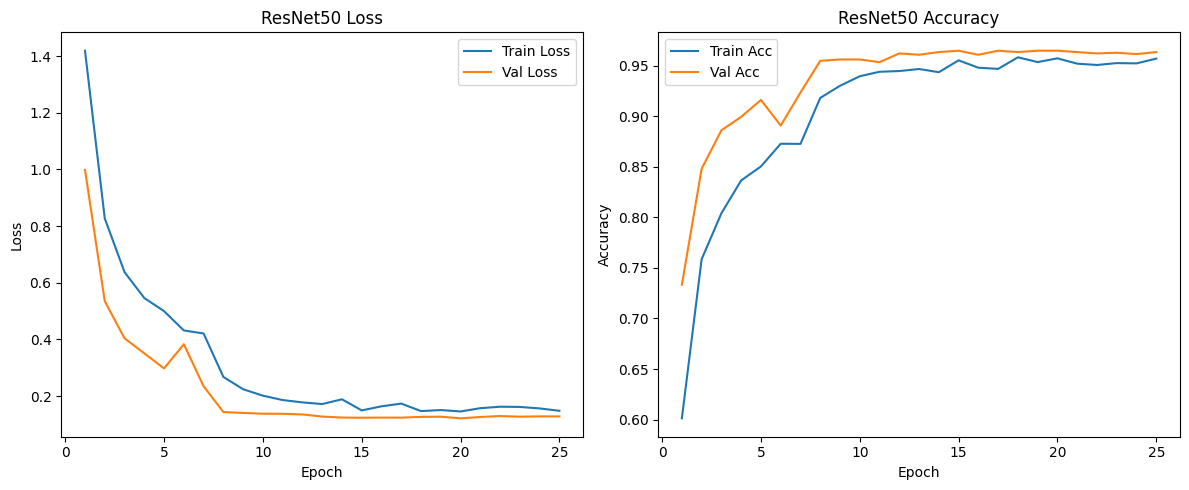

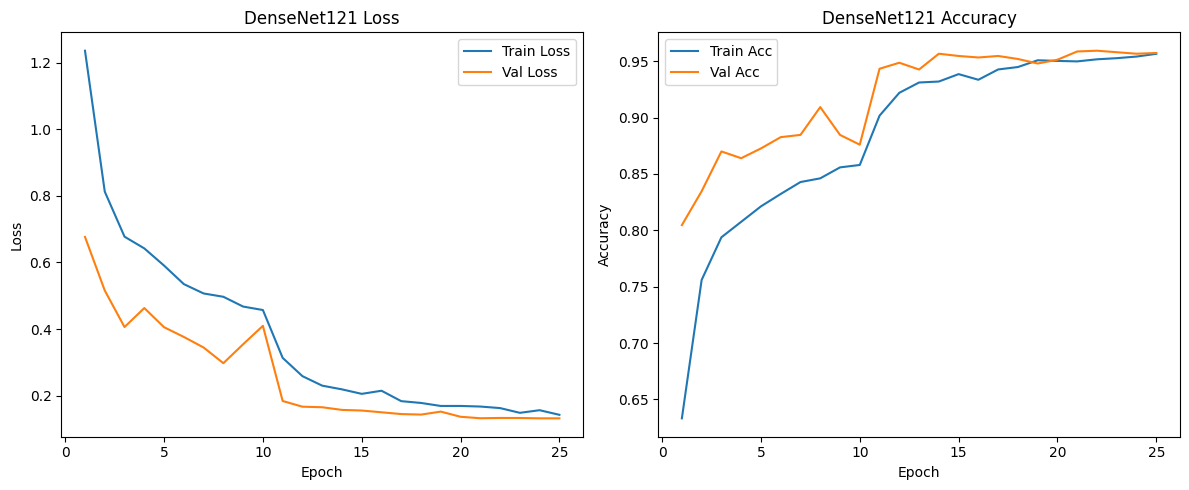

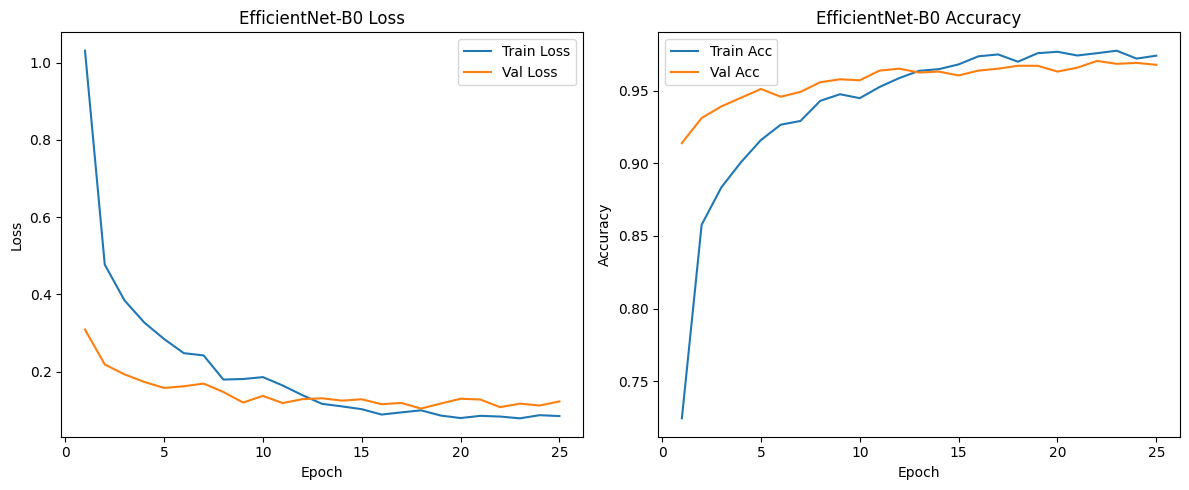

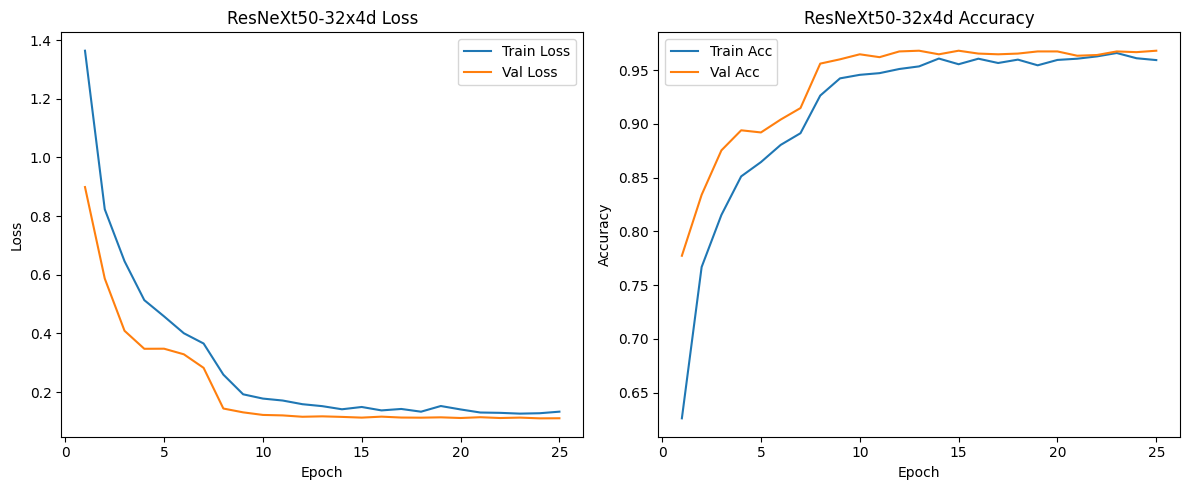

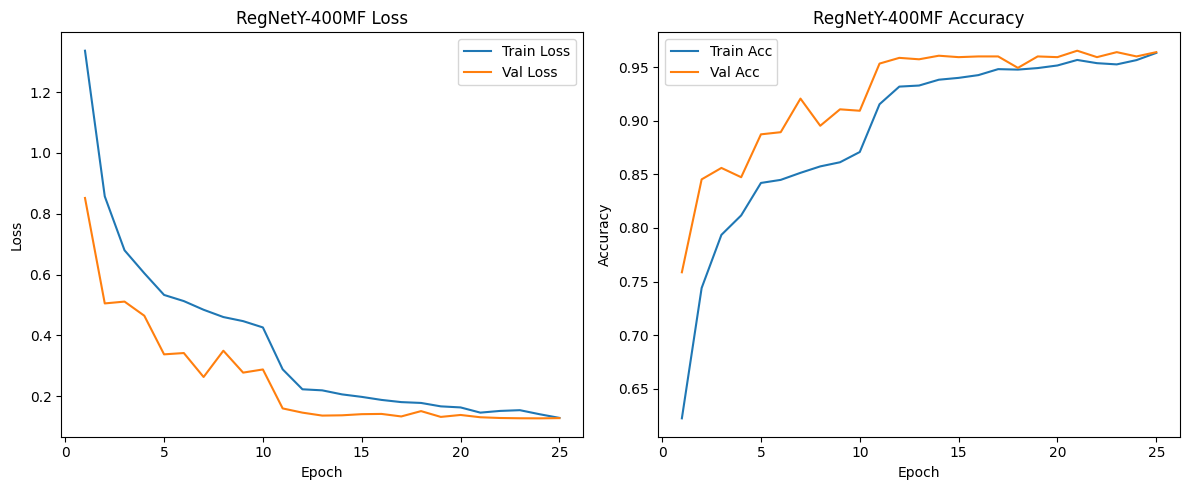

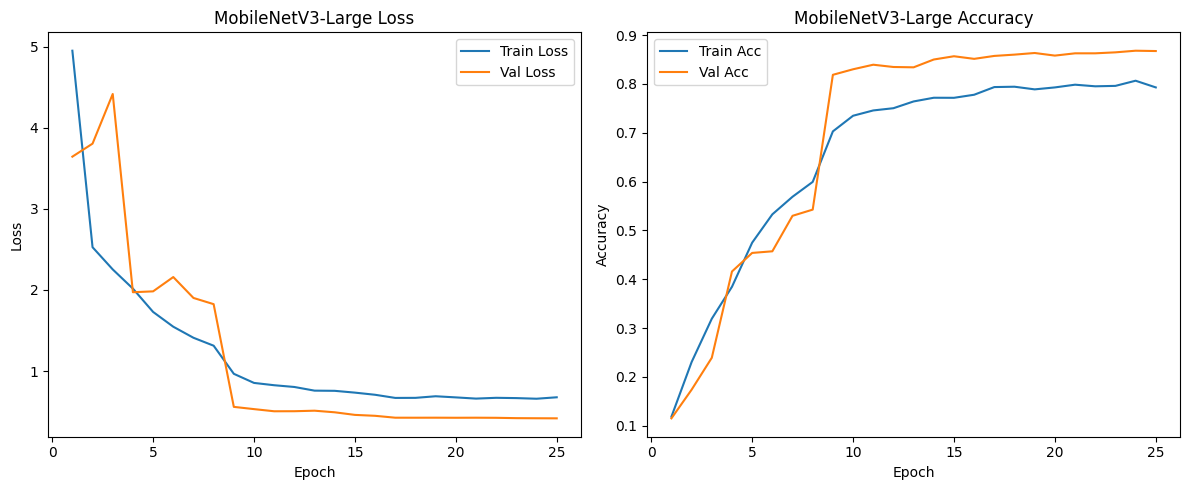

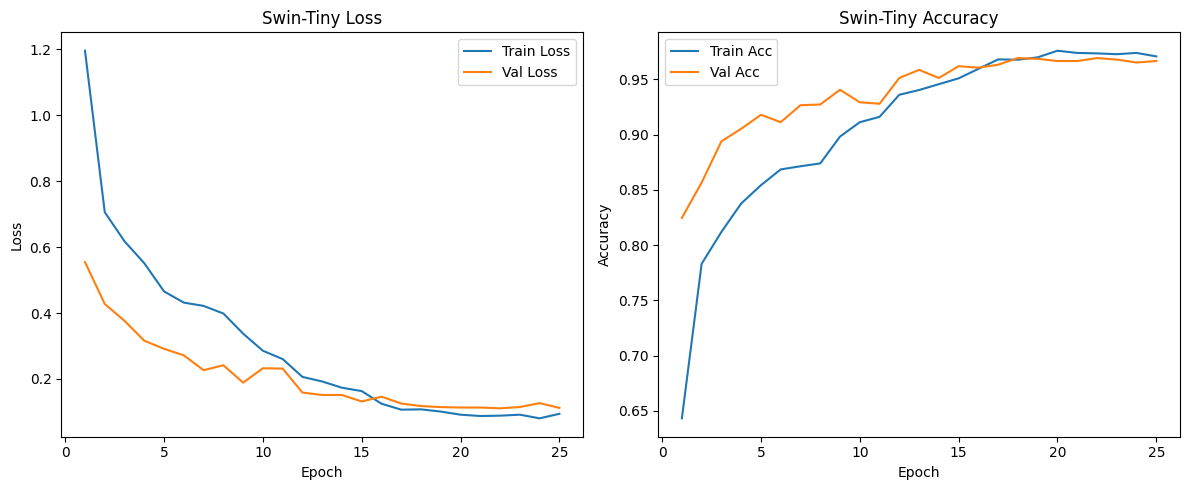

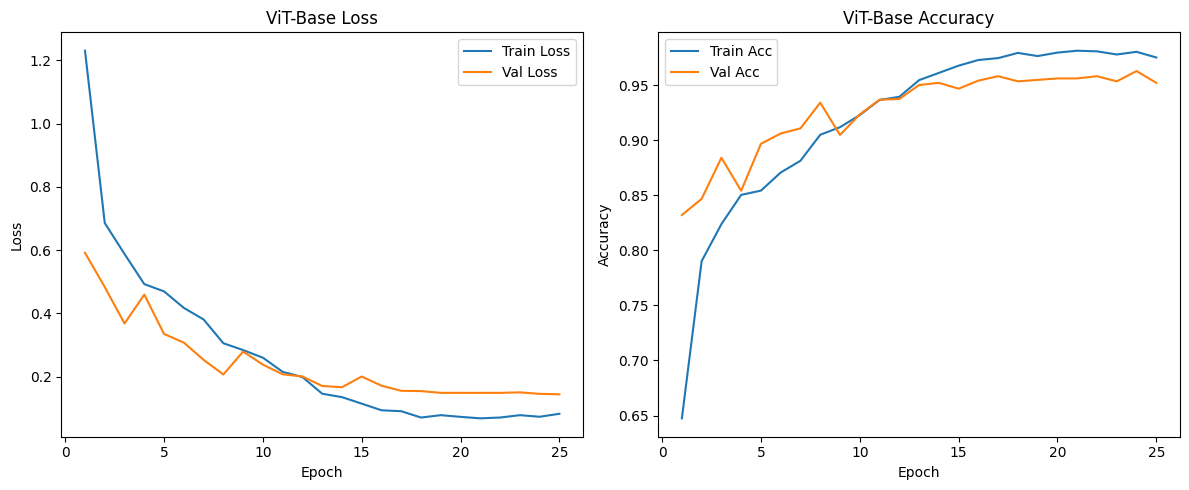

In [60]:
import matplotlib.pyplot as plt

# Map display names → history-variable names
hist_vars = {
    'ResNet50':          'hist_resnet',
    'DenseNet121':       'hist_dn',
    'EfficientNet-B0':   'hist_eff',
    'ResNeXt50-32x4d':   'hist_rx',
    'ConvNeXt-Tiny':     'hist_cn',
    'RegNetY-400MF':     'hist_ry',
    'MobileNetV3-Large': 'hist_mn',
    'Swin-Tiny':         'hist_sw',
    'ViT-Base':          'hist_vit'
}

# Grab only the ones that actually exist right now
all_hist = {
    name: globals()[var_name]
    for name, var_name in hist_vars.items()
    if var_name in globals()
}

if not all_hist:
    raise RuntimeError("No history variables found! Make sure you've run all your training cells.")

# Plot
for name, h in all_hist.items():
    epochs = range(1, len(h['train_loss']) + 1)

    plt.figure(figsize=(12, 5))
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, h['train_loss'], label='Train Loss')
    plt.plot(epochs, h['val_loss'],   label='Val Loss')
    plt.title(f'{name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, h['train_acc'], label='Train Acc')
    plt.plot(epochs, h['val_acc'],   label='Val Acc')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
